# Installing required dependencies

In [1]:
!pip install kaggle

In [6]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=fe518d7469d5626b9e3b19cebd55f68d92011c20b8ca140f1d4f525bcbfb2b5a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=11bfada44d683d899684bafb581d1d586c01df9ea9f9882cbcf1c3f098b0025b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

# Connecting with Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sppokharel","key":"2d884a88aac46d8b51670677402143be"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Loading the Dataset

In [4]:
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset
License(s): other
100% 3.79G/3.79G [00:55<00:00, 92.3MB/s]
100% 3.79G/3.79G [00:55<00:00, 73.3MB/s]


In [5]:
import zipfile

with zipfile.ZipFile("/content/deepglobe-road-extraction-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("deepglobe-road-extraction-dataset")

# Import Required Dependencies

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
from tqdm import tqdm
import segmentation_models_pytorch as smp

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Connect with GPU

In [8]:
if torch.cuda.is_available():
    print("GPU is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU is available!
GPU Name: Tesla T4


# Dataset Exploration and Preprocessing

In [47]:
df = pd.read_csv('/content/deepglobe-road-extraction-dataset/metadata.csv')
df.head(10)

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png
5,100773,train,train/100773_sat.jpg,train/100773_mask.png
6,100841,train,train/100841_sat.jpg,train/100841_mask.png
7,100867,train,train/100867_sat.jpg,train/100867_mask.png
8,100892,train,train/100892_sat.jpg,train/100892_mask.png
9,101225,train,train/101225_sat.jpg,train/101225_mask.png


In [48]:
df = df[df['split']=='train']

In [51]:
df

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png
...,...,...,...,...
6221,999431,train,train/999431_sat.jpg,train/999431_mask.png
6222,999531,train,train/999531_sat.jpg,train/999531_mask.png
6223,999667,train,train/999667_sat.jpg,train/999667_mask.png
6224,999764,train,train/999764_sat.jpg,train/999764_mask.png


## Image Resizing and Mask Grayscaling

The images (satellite images and masks) are sized to 128 x 128. The masks are converted to grayscale for binary segmentation.

Luminance formula has been used to conert the RGB image to grayscale.

Y = 0.2989 * R + 0.5870 * G + 0.1140 * B

In [52]:
images = []
masks = []
for i in tqdm(range(6226)):
    path='/content/deepglobe-road-extraction-dataset/'
    image = plt.imread(path+df['sat_image_path'][i])
    mask = plt.imread(path+df['mask_path'][i])
    image = cv2.resize(image,(128,128),interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask,(128,128),interpolation=cv2.INTER_CUBIC)
    grayimg = mask[:,:,0]*0.2989+mask[:,:,1]*0.5870+mask[:,:,2]*0.1140
    images.append(image)
    masks.append(grayimg)

100%|██████████| 6226/6226 [02:55<00:00, 35.39it/s]


## Augmentation

The images are augmented and the dataset is extended.

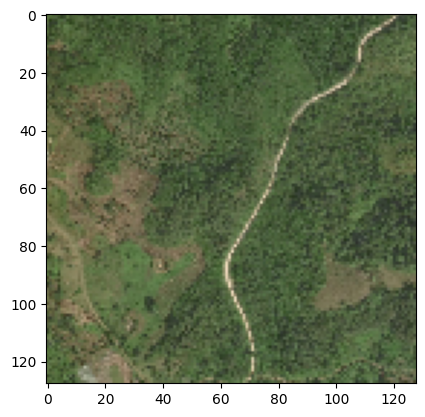

In [14]:
plt.imshow(images[0])

In [15]:
masks[0].shape

(128, 128)

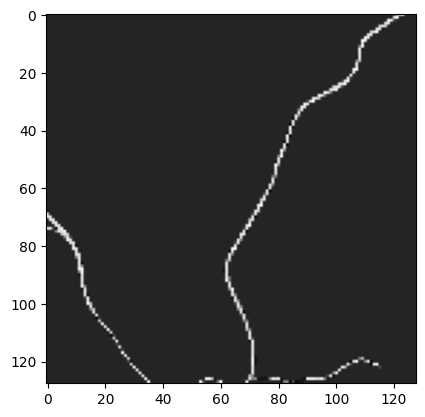

In [16]:
plt.imshow(masks[0],cmap='gray')

In [17]:
def get_augmentations(image_size = 128, crop_prob = 1):
    return A.Compose([

        A.RandomCrop(width = image_size, height = image_size, p=crop_prob),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.25),
    ],p=1)

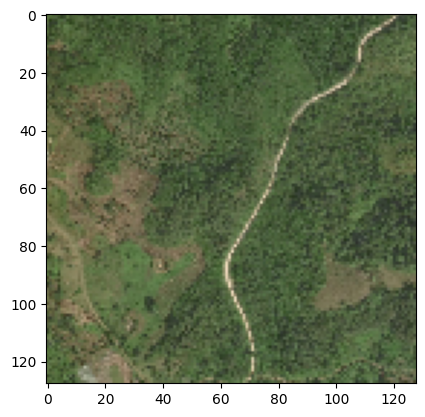

In [18]:
plt.imshow(images[0])

In [53]:
new_img = get_augmentations()(image = images[0],mask = masks[0])

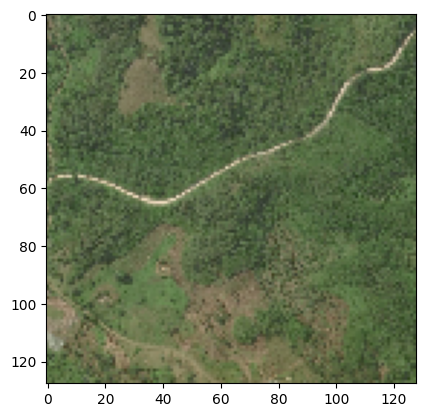

In [54]:
plt.imshow(new_img['image'])

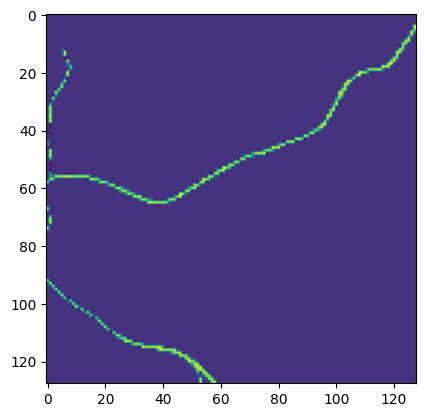

In [55]:
plt.imshow(new_img['mask'])

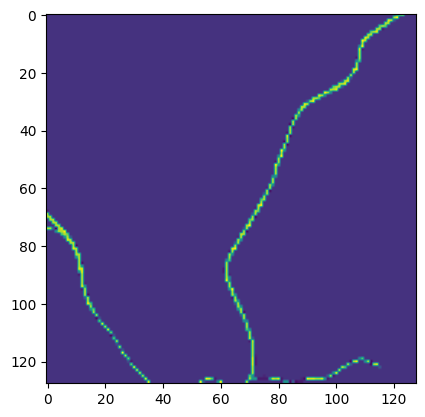

In [56]:
plt.imshow(masks[0])

In [23]:
timgs,tmasks = images.copy(),masks.copy()
for image,mask in tqdm(zip(images,masks)):
    aug = get_augmentations()(image=image,mask=mask)
    timgs.append(aug['image'])
    tmasks.append(aug['mask'])

6226it [00:05, 1099.23it/s]


## Dataset Split and Loading

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(timgs,tmasks,test_size=0.05,random_state=42)

In [25]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [26]:
y_train.shape

(11829, 128, 128)

In [57]:
class SatelliteDataset(Dataset):
    def __init__(self, images, masks, augmentation=None):
        self.images = images
        self.masks = masks
        self.augmentation = augmentation

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Transform to tensor and add channel dimension to mask
        return torch.from_numpy(image.transpose(2, 0, 1)).float(), torch.from_numpy(mask).float().unsqueeze(0)

In [28]:
train_dataset = SatelliteDataset(X_train, y_train, augmentation=get_augmentations())
test_dataset = SatelliteDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Necessary Metrics

### Dice Score

Dice Score measures overlap between the original and predicted masks.

In [27]:
def dice_score(pred, target, epsilon=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.mean()

### Intersection Over Union

IoU measures the overlap between predicted segmentation and actual segmentation.

In [58]:
def iou_score(pred, target, epsilon=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.mean()

# Model and Training

U-Net architecture has been used. For its encoder, a VGG16 network trained on Imagenet dataset was used.
Adam optimizer has been used and the learning rate has been set to 0.001. Dice loss has been used as the loss function for the same reason Dice Score has been used.

In [29]:
import segmentation_models_pytorch as smp
model = smp.Unet(encoder_name="vgg16", encoder_weights="imagenet", in_channels=3, classes=1)
# Move the model to the configured device
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = smp.losses.DiceLoss(mode='binary')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.6MB/s]


Training and validation has been done below.

In [30]:
train_losses, val_losses, train_dice_scores, val_dice_scores, train_iou_scores, val_iou_scores = [], [], [], [], [], []

for epoch in range(50):  # Adjust the number of epochs as necessary
    model.train()
    total_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    train_dice_scores.append(dice_score(outputs, masks).item())
    train_iou_scores.append(iou_score(outputs, masks).item())

    # Validation phase
    model.eval()
    total_val_loss, val_dice, val_iou = 0, [], []
    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss = loss_func(outputs, masks)
            total_val_loss += val_loss.item()
            val_dice.append(dice_score(outputs, masks).item())
            val_iou.append(iou_score(outputs, masks).item())
        val_losses.append(total_val_loss / len(test_loader))
        val_dice_scores.append(np.mean(val_dice))
        val_iou_scores.append(np.mean(val_iou))

    print(f'Epoch {epoch}: Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Dice: {train_dice_scores[-1] if train_dice_scores else 0}, Val Dice: {val_dice_scores[-1] if val_dice_scores else 0}, Train IoU: {train_iou_scores[-1] if train_iou_scores else 0}, Val IoU: {val_iou_scores[-1] if val_iou_scores else 0}')

100%|██████████| 39/39 [00:01<00:00, 25.68it/s]


Epoch 0: Train Loss: 0.5820011359614294, Val Loss: 0.4922984410554935, Train Dice: 0.3921821415424347, Val Dice: 0.47001547920398223, Train IoU: 0.26740410923957825, Val IoU: 0.3263086042343042


100%|██████████| 39/39 [00:01<00:00, 26.58it/s]


Epoch 1: Train Loss: 0.4823008240074725, Val Loss: 0.4580937700393872, Train Dice: 0.31892696022987366, Val Dice: 0.5092645532045609, Train IoU: 0.20438070595264435, Val IoU: 0.36378586980012745


100%|██████████| 39/39 [00:01<00:00, 26.67it/s]


Epoch 2: Train Loss: 0.4544234075256296, Val Loss: 0.4925896189151666, Train Dice: 0.46878811717033386, Val Dice: 0.43679336936045915, Train IoU: 0.32987380027770996, Val IoU: 0.31305238872002333


100%|██████████| 39/39 [00:01<00:00, 26.60it/s]


Epoch 3: Train Loss: 0.43708834688405734, Val Loss: 0.45883189867704344, Train Dice: 0.6218670606613159, Val Dice: 0.503609170516332, Train IoU: 0.4596676826477051, Val IoU: 0.3653792502024235


100%|██████████| 39/39 [00:01<00:00, 26.54it/s]


Epoch 4: Train Loss: 0.4242164428975131, Val Loss: 0.41999253707054335, Train Dice: 0.598522961139679, Val Dice: 0.5492015068347638, Train IoU: 0.44562506675720215, Val IoU: 0.4020125988202217


100%|██████████| 39/39 [00:01<00:00, 26.56it/s]


Epoch 5: Train Loss: 0.414512982803422, Val Loss: 0.41589250625708163, Train Dice: 0.5089029669761658, Val Dice: 0.5420412841515664, Train IoU: 0.35392260551452637, Val IoU: 0.39890316663644254


100%|██████████| 39/39 [00:01<00:00, 26.45it/s]


Epoch 6: Train Loss: 0.4052126365738946, Val Loss: 0.41350340384703416, Train Dice: 0.42525169253349304, Val Dice: 0.5562345034036881, Train IoU: 0.2806210219860077, Val IoU: 0.41216937242410123


100%|██████████| 39/39 [00:01<00:00, 25.82it/s]


Epoch 7: Train Loss: 0.3983624852992393, Val Loss: 0.39530013310603607, Train Dice: 0.6251134276390076, Val Dice: 0.5645440006867434, Train IoU: 0.47322168946266174, Val IoU: 0.41858115104528576


100%|██████████| 39/39 [00:01<00:00, 26.57it/s]


Epoch 8: Train Loss: 0.39596651695870067, Val Loss: 0.40410120976276886, Train Dice: 0.644299328327179, Val Dice: 0.5645570693871914, Train IoU: 0.4787699282169342, Val IoU: 0.4175842839937944


100%|██████████| 39/39 [00:01<00:00, 26.49it/s]


Epoch 9: Train Loss: 0.38996619477465344, Val Loss: 0.3864909395193442, Train Dice: 0.5718275904655457, Val Dice: 0.5771709634707525, Train IoU: 0.4193139970302582, Val IoU: 0.43083426967645305


100%|██████████| 39/39 [00:01<00:00, 26.52it/s]


Epoch 10: Train Loss: 0.38500968362834004, Val Loss: 0.3925648912405356, Train Dice: 0.6623162627220154, Val Dice: 0.5821864971747766, Train IoU: 0.5109519362449646, Val IoU: 0.4303333491851122


100%|██████████| 39/39 [00:01<00:00, 26.57it/s]


Epoch 11: Train Loss: 0.38115821319657406, Val Loss: 0.3790572392634856, Train Dice: 0.5751628875732422, Val Dice: 0.5943093819495959, Train IoU: 0.41997623443603516, Val IoU: 0.4429785173672896


100%|██████████| 39/39 [00:01<00:00, 26.58it/s]


Epoch 12: Train Loss: 0.37743197727847744, Val Loss: 0.37607944164520657, Train Dice: 0.5822413563728333, Val Dice: 0.5798214582296518, Train IoU: 0.4218021333217621, Val IoU: 0.4360371178541428


100%|██████████| 39/39 [00:01<00:00, 26.11it/s]


Epoch 13: Train Loss: 0.37310289434484534, Val Loss: 0.36862185979500794, Train Dice: 0.5424689650535583, Val Dice: 0.5971136077856406, Train IoU: 0.3957839906215668, Val IoU: 0.4484381431188339


100%|██████████| 39/39 [00:01<00:00, 25.98it/s]


Epoch 14: Train Loss: 0.371358498528197, Val Loss: 0.3729454080263774, Train Dice: 0.5597461462020874, Val Dice: 0.5937476433240451, Train IoU: 0.4020818769931793, Val IoU: 0.4460228330049759


100%|██████████| 39/39 [00:01<00:00, 26.53it/s]


Epoch 15: Train Loss: 0.3679954198566643, Val Loss: 0.36654612498405653, Train Dice: 0.7196548581123352, Val Dice: 0.5997207057781708, Train IoU: 0.5718345642089844, Val IoU: 0.452237008473812


100%|██████████| 39/39 [00:01<00:00, 26.62it/s]


Epoch 16: Train Loss: 0.36515570798435726, Val Loss: 0.366822375701024, Train Dice: 0.5299053192138672, Val Dice: 0.6011462089342948, Train IoU: 0.3677820563316345, Val IoU: 0.4544190833201775


100%|██████████| 39/39 [00:01<00:00, 26.54it/s]


Epoch 17: Train Loss: 0.3635020003930942, Val Loss: 0.37608036628136265, Train Dice: 0.5243238210678101, Val Dice: 0.5972308210837536, Train IoU: 0.3735756576061249, Val IoU: 0.4475275385074126


100%|██████████| 39/39 [00:01<00:00, 26.66it/s]


Epoch 18: Train Loss: 0.3601933464005187, Val Loss: 0.37168173300914276, Train Dice: 0.5876583456993103, Val Dice: 0.5954140883225661, Train IoU: 0.4388490319252014, Val IoU: 0.45028015665518933


100%|██████████| 39/39 [00:01<00:00, 25.91it/s]


Epoch 19: Train Loss: 0.35766937990446346, Val Loss: 0.3591084373302949, Train Dice: 0.6849167943000793, Val Dice: 0.6099134194545257, Train IoU: 0.5341283679008484, Val IoU: 0.4624293354841379


100%|██████████| 39/39 [00:01<00:00, 26.61it/s]


Epoch 20: Train Loss: 0.35628053707045476, Val Loss: 0.37947436173756915, Train Dice: 0.34390923380851746, Val Dice: 0.5707746362074827, Train IoU: 0.23876166343688965, Val IoU: 0.43135064916732985


100%|██████████| 39/39 [00:01<00:00, 26.47it/s]


Epoch 21: Train Loss: 0.35453882950383264, Val Loss: 0.36236090843494123, Train Dice: 0.5223230719566345, Val Dice: 0.6029534874818264, Train IoU: 0.3632151782512665, Val IoU: 0.45636174312004674


100%|██████████| 39/39 [00:01<00:00, 26.59it/s]


Epoch 22: Train Loss: 0.351359258712949, Val Loss: 0.3572933398760282, Train Dice: 0.7586678862571716, Val Dice: 0.6094175271498852, Train IoU: 0.6279081106185913, Val IoU: 0.46162982476063263


100%|██████████| 39/39 [00:01<00:00, 26.68it/s]


Epoch 23: Train Loss: 0.3487348389786643, Val Loss: 0.3449785266167078, Train Dice: 0.6006637811660767, Val Dice: 0.6202763059200385, Train IoU: 0.4376794397830963, Val IoU: 0.4739779883470291


100%|██████████| 39/39 [00:01<00:00, 26.67it/s]


Epoch 24: Train Loss: 0.34774129551810185, Val Loss: 0.36054434531774276, Train Dice: 0.6820874810218811, Val Dice: 0.6107321763649965, Train IoU: 0.5285978317260742, Val IoU: 0.4606096148490906


100%|██████████| 39/39 [00:01<00:00, 25.72it/s]


Epoch 25: Train Loss: 0.3487825718280431, Val Loss: 0.35306201531336856, Train Dice: 0.6890078783035278, Val Dice: 0.6077462465335162, Train IoU: 0.5561710000038147, Val IoU: 0.462794073117085


100%|██████████| 39/39 [00:01<00:00, 26.39it/s]


Epoch 26: Train Loss: 0.346006873088914, Val Loss: 0.3454364782724625, Train Dice: 0.686379075050354, Val Dice: 0.6171263379928393, Train IoU: 0.5275456309318542, Val IoU: 0.4715996224146623


100%|██████████| 39/39 [00:01<00:00, 26.68it/s]


Epoch 27: Train Loss: 0.342260072199074, Val Loss: 0.3464820812910031, Train Dice: 0.7524306774139404, Val Dice: 0.6101025816721793, Train IoU: 0.6117491126060486, Val IoU: 0.4664385127715575


100%|██████████| 39/39 [00:01<00:00, 26.61it/s]


Epoch 28: Train Loss: 0.34232200303593197, Val Loss: 0.3490534164966681, Train Dice: 0.5417991876602173, Val Dice: 0.6101336922401037, Train IoU: 0.41207247972488403, Val IoU: 0.465808677367675


100%|██████████| 39/39 [00:01<00:00, 26.70it/s]


Epoch 29: Train Loss: 0.3399656447204384, Val Loss: 0.35287616497431046, Train Dice: 0.7689275145530701, Val Dice: 0.6113909345406753, Train IoU: 0.6286482810974121, Val IoU: 0.46655932985819304


100%|██████████| 39/39 [00:01<00:00, 26.64it/s]


Epoch 30: Train Loss: 0.3384093972476753, Val Loss: 0.34169254700342816, Train Dice: 0.5390805602073669, Val Dice: 0.6182592801558666, Train IoU: 0.39751145243644714, Val IoU: 0.4742605754962334


100%|██████████| 39/39 [00:01<00:00, 25.99it/s]


Epoch 31: Train Loss: 0.33756184384629534, Val Loss: 0.3440884840794099, Train Dice: 0.42550745606422424, Val Dice: 0.6198865679594187, Train IoU: 0.30196869373321533, Val IoU: 0.47348119356693363


100%|██████████| 39/39 [00:01<00:00, 25.99it/s]


Epoch 32: Train Loss: 0.3370649086462485, Val Loss: 0.3385915802075313, Train Dice: 0.732780933380127, Val Dice: 0.6242341903539804, Train IoU: 0.593542218208313, Val IoU: 0.4785518363500253


100%|██████████| 39/39 [00:01<00:00, 26.63it/s]


Epoch 33: Train Loss: 0.3336372518861616, Val Loss: 0.339224038979946, Train Dice: 0.6571906208992004, Val Dice: 0.6287094079531156, Train IoU: 0.5019789934158325, Val IoU: 0.4799897815936651


100%|██████████| 39/39 [00:01<00:00, 26.57it/s]


Epoch 34: Train Loss: 0.3348488132695894, Val Loss: 0.3396988067871485, Train Dice: 0.6046470403671265, Val Dice: 0.6168885093468887, Train IoU: 0.4460204541683197, Val IoU: 0.4738287581847264


100%|██████████| 39/39 [00:01<00:00, 26.60it/s]


Epoch 35: Train Loss: 0.3318594749714877, Val Loss: 0.337272442304171, Train Dice: 0.7008390426635742, Val Dice: 0.6201402636674734, Train IoU: 0.5457688570022583, Val IoU: 0.4765632282464932


100%|██████████| 39/39 [00:01<00:00, 26.51it/s]


Epoch 36: Train Loss: 0.33410921394824983, Val Loss: 0.33944891813473826, Train Dice: 0.5564779043197632, Val Dice: 0.6197918775754098, Train IoU: 0.4242493212223053, Val IoU: 0.47446438670158386


100%|██████████| 39/39 [00:01<00:00, 26.48it/s]


Epoch 37: Train Loss: 0.3313228805322905, Val Loss: 0.33565053725853944, Train Dice: 0.6307330131530762, Val Dice: 0.6259104257974869, Train IoU: 0.46658429503440857, Val IoU: 0.48094133459604704


100%|██████████| 39/39 [00:01<00:00, 26.05it/s]


Epoch 38: Train Loss: 0.32825625377732354, Val Loss: 0.33287011812894773, Train Dice: 0.7284817099571228, Val Dice: 0.6364315977463355, Train IoU: 0.5830268859863281, Val IoU: 0.48950774394548857


100%|██████████| 39/39 [00:01<00:00, 25.78it/s]


Epoch 39: Train Loss: 0.3291285090349816, Val Loss: 0.3293622518197084, Train Dice: 0.5778221487998962, Val Dice: 0.6352973534510686, Train IoU: 0.41834306716918945, Val IoU: 0.4891666143368452


100%|██████████| 39/39 [00:01<00:00, 25.90it/s]


Epoch 40: Train Loss: 0.3265890363905881, Val Loss: 0.3294054009975531, Train Dice: 0.5423915386199951, Val Dice: 0.6353000646982437, Train IoU: 0.3974035084247589, Val IoU: 0.48944286963878536


100%|██████████| 39/39 [00:01<00:00, 26.53it/s]


Epoch 41: Train Loss: 0.3253395150642137, Val Loss: 0.333544848821102, Train Dice: 0.6241774559020996, Val Dice: 0.6272576451301575, Train IoU: 0.4553750455379486, Val IoU: 0.4816492543770717


100%|██████████| 39/39 [00:01<00:00, 26.51it/s]


Epoch 42: Train Loss: 0.3248063954147133, Val Loss: 0.3283728789060544, Train Dice: 0.6361843943595886, Val Dice: 0.6291193870397714, Train IoU: 0.4806419014930725, Val IoU: 0.48590374145752346


100%|██████████| 39/39 [00:01<00:00, 26.47it/s]


Epoch 43: Train Loss: 0.32364746501316893, Val Loss: 0.34040618859804594, Train Dice: 0.6907407641410828, Val Dice: 0.6284810258791997, Train IoU: 0.5456892848014832, Val IoU: 0.4788982745928642


100%|██████████| 39/39 [00:01<00:00, 26.39it/s]


Epoch 44: Train Loss: 0.3230460985286816, Val Loss: 0.32583287281867784, Train Dice: 0.5335185527801514, Val Dice: 0.6325722749416645, Train IoU: 0.3844495713710785, Val IoU: 0.4889758817660503


100%|██████████| 39/39 [00:01<00:00, 25.86it/s]


Epoch 45: Train Loss: 0.32234879305233827, Val Loss: 0.333450864522885, Train Dice: 0.6171464920043945, Val Dice: 0.6306344820902898, Train IoU: 0.4607454240322113, Val IoU: 0.4870167825466547


100%|██████████| 39/39 [00:01<00:00, 26.62it/s]


Epoch 46: Train Loss: 0.32091127231314376, Val Loss: 0.3288487012569721, Train Dice: 0.5435341000556946, Val Dice: 0.6380944282580645, Train IoU: 0.38245704770088196, Val IoU: 0.4912678981438661


100%|██████████| 39/39 [00:01<00:00, 26.64it/s]


Epoch 47: Train Loss: 0.32016027658372315, Val Loss: 0.32633552184471715, Train Dice: 0.6945381760597229, Val Dice: 0.6444007739042624, Train IoU: 0.5457658767700195, Val IoU: 0.4962958181515718


100%|██████████| 39/39 [00:01<00:00, 26.50it/s]


Epoch 48: Train Loss: 0.3200552502193966, Val Loss: 0.32664905908780223, Train Dice: 0.6865368485450745, Val Dice: 0.6358093451230954, Train IoU: 0.5350040793418884, Val IoU: 0.4912295570740333


100%|██████████| 39/39 [00:01<00:00, 26.53it/s]

Epoch 49: Train Loss: 0.3187061705299326, Val Loss: 0.3253955535399608, Train Dice: 0.5687800645828247, Val Dice: 0.6405406640126154, Train IoU: 0.40982967615127563, Val IoU: 0.4935433451945965


# Visualizations

## Loss vs Epochs

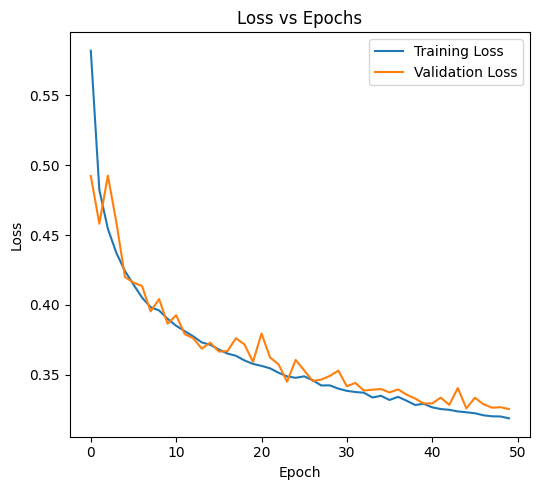

In [60]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

There is a gradual decrease in both training and validation losses.

## Dice Score vs Epochs

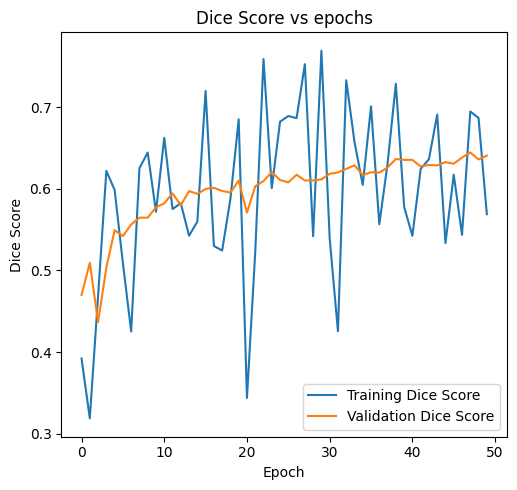

In [61]:
# Plotting Dice score
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 2)
plt.plot(train_dice_scores, label='Training Dice Score')
plt.plot(val_dice_scores, label='Validation Dice Score')
plt.title('Dice Score vs epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.tight_layout()
plt.show()

While the training dice score is fluctuating suggesting that the model is having a hard time generalizing the training data. The validation dice score is rising slowly suggesting it is generalizing the validation data better.

## IoU Score vs Epochs

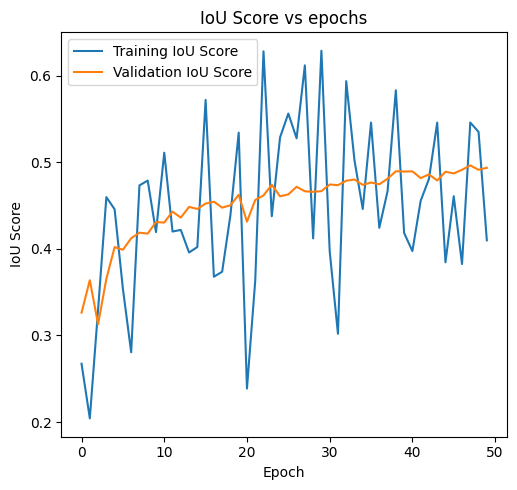

In [62]:
# Plotting IoU score
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 3)
plt.plot(train_iou_scores, label='Training IoU Score')
plt.plot(val_iou_scores, label='Validation IoU Score')
plt.title('IoU Score vs epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.tight_layout()
plt.show()

The reasoning behind trends for Training IoU score and Validation IoU score is similar to that of trend of Dice score above.

# Saving the Checkpoint

In [59]:
import os

# Define the path where the checkpoint will be saved
checkpoint_dir = "/content/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # Create directory if it doesn't exist
checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pth")

# Save the checkpoint
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_dice_scores': train_dice_scores,
    'val_dice_scores': val_dice_scores,
    'train_iou_scores': train_iou_scores,
    'val_iou_scores': val_iou_scores,
}, checkpoint_path)

print(f"Checkpoint saved at {checkpoint_path}")

Checkpoint saved at /content/checkpoints/model_epoch_49.pth
